In [69]:
from google.colab import output
output.enable_custom_widget_manager()

In [88]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import random
import matplotlib.animation as animation
from matplotlib.colors import LinearSegmentedColormap

In [71]:

# Función para inicializar el grid con celdas infectadas aleatoriamente
def initialize_grid(M, N, infected_cells):
    grid = np.zeros((M, N), dtype=int)  # Todas las celdas son susceptibles inicialmente (0)

    # Elegir I0 celdas aleatorias para ser infectadas
    for cell in infected_cells:
        grid[cell] = 1  # Infectadas (estado 1)

    return grid

# Función para obtener la vecindad de una celda (i, j) con radio rad
def get_neighborhood(grid, i, j, rad):
    M, N = grid.shape
    neighborhood = grid[max(0, i-rad):min(M, i+rad+1), max(0, j-rad):min(N, j+rad+1)]
    return neighborhood

# Función para ejecutar la simulación
def simulate_sir(M, N, T, infected_cells, rad, beta, gamma):
    grid = initialize_grid(M, N, infected_cells)
    grid_history = []  # Historial del grid
    population_counts = []  # Historial de S, I, R

    for t in range(T):
        new_grid = grid.copy()
        S_count = 0
        I_count = 0
        R_count = 0

        for i in range(M):
            for j in range(N):
                if grid[i, j] == 0:  # Susceptible
                    neighborhood = get_neighborhood(grid, i, j, rad)
                    infected_neighbors = np.sum(neighborhood == 1)
                    total_neighbors = neighborhood.size

                    # Probabilidad de infección
                    if infected_neighbors > 0:
                        infection_probability = beta * (infected_neighbors / total_neighbors)
                        if random.random() < infection_probability:
                            new_grid[i, j] = 1  # Infectar la celda

                elif grid[i, j] == 1:  # Infectado
                    # Probabilidad de recuperación
                    if random.random() < gamma:
                        new_grid[i, j] = 2  # Recuperar la celda

        # Actualizar el grid y registrar las cantidades de S, I, R
        grid = new_grid
        S_count = np.sum(grid == 0)
        I_count = np.sum(grid == 1)
        R_count = np.sum(grid == 2)

        grid_history.append(grid.copy())
        population_counts.append((S_count, I_count, R_count))

    return grid_history, population_counts


In [72]:
# Función para graficar el promedio de S, I, R
def nexp_plot(S_avg, I_avg, R_avg, T, beta, gamma):
    t = np.arange(T)
    plt.figure(figsize=(10, 6))
    plt.plot(t, S_avg, label="S(t) - Susceptibles", color='blue')
    plt.plot(t, I_avg, label="I(t) - Infectados",color='green')
    plt.plot(t, R_avg, label="R(t) - Recuperados",color='red')
    plt.title(f"Resultados para β={beta}, γ={gamma}")
    plt.xlabel("Tiempo")
    plt.ylabel("Población")
    plt.legend()

In [73]:
def run_experiments(Nexp, M, N, T, infected_positions, rad, beta, gamma):
    all_grid_histories = np.zeros((Nexp, T, M, N), dtype=float)

    for exp in range(Nexp):
        grid_history, _ = simulate_sir(M, N, T, infected_positions, rad, beta, gamma)
        all_grid_histories[exp] = np.array(grid_history)

    # Calcular la dinámica espacial promedio
    avg_grid_history = np.mean(all_grid_histories, axis=0)

    return avg_grid_history


In [89]:
def generate_animated_avg_grid_video(avg_grid_history, output_filename="sir_simulation.mp4"):
    colors = ['purple', 'yellow', 'green'] # Morado: Susceptible, Amarillo: Infectado, Verde: Recuperado
    cmap = LinearSegmentedColormap.from_list("SIR_cmap", colors, N=256)

    fig, ax = plt.subplots()
    img = ax.imshow(avg_grid_history[0], cmap=cmap, vmin=0, vmax=2)

    def update(frame):
        img.set_data(avg_grid_history[frame])
        ax.set_title(f'Día {frame}')
        return [img]

    ani = animation.FuncAnimation(fig, update, frames=len(avg_grid_history), blit=False)

    # Guardar el video en formato mp4 usando ffmpeg
    ani.save(output_filename, writer='ffmpeg', fps=5)
    plt.show()

In [102]:
# Parámetros del modelo
M = 50  # Tamaño del grid en filas
N = 50  # Tamaño del grid en columnas
T = 100  # Tiempo de simulación
infected_positions = [(10, 10), (20, 20), (30, 30), (15, 40), (49, 10)]  # Posiciones infectadas
rad = 1  # Radio de interacción
beta = 0.7  # Probabilidad de infección
gamma = 0.25  # Probabilidad de recuperación
Nexp = 10  # Número de experimentos


avg_grid_history = run_experiments(Nexp, M, N, T, infected_positions, rad, beta, gamma)



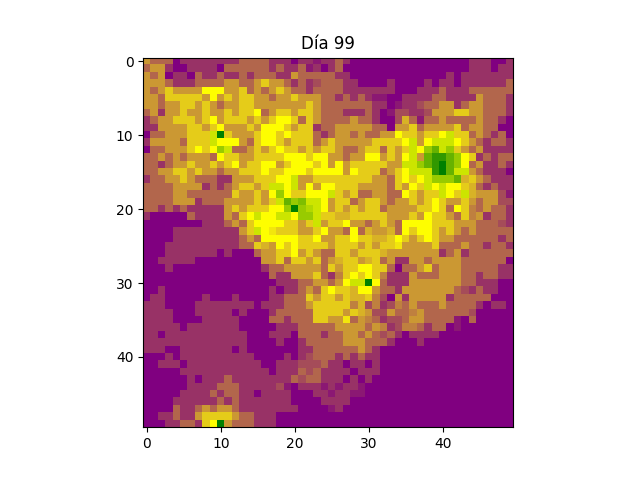

In [103]:
generate_animated_avg_grid_video(avg_grid_history, "sir_simulation_20.mp4")